In [21]:
import segmentation_models_pytorch as smp
import torch

model = smp.Unet(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=4,                      # model output channels (number of classes in your dataset)
)

model.load_state_dict(torch.load('checkpoint.pt'))
model.cuda()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [22]:
import os

path = 'data/MnM-2/validation'
patients = os.listdir(path)
len(patients)

40

In [23]:
import shutil

dest = 'preds'
#shutil.rmtree(dest)
os.makedirs(dest)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'preds'

In [24]:
max_val = {
    'LA_ED': 4104.,
    'LA_ES': 7875.,
    'SA_ED': 11510.,
    'SA_ES': 9182.
}

In [25]:
import albumentations as A

resize = A.Resize(224, 224)

In [26]:
import nibabel as nib

def pred_la(patient, file):
    img = nib.load(f'{path}/{patient}/{patient}_{file}.nii.gz')
    img_data = img.get_fdata() / max_val[file]
    resized = resize(image=img_data[...,0])['image']
    img_t = torch.from_numpy(resized).float().unsqueeze(0)
    output = model.predict(img_t.unsqueeze(0).cuda())
    output = torch.sigmoid(output)
    mask = torch.argmax(output[0,...], axis=0).float().cpu().numpy()
    mask_resized = np.rint(A.Resize(*img.shape[:2])(image=mask)['image'])[...,None]
    nib.save(nib.Nifti1Image(mask_resized, img.affine), f'{dest}/{patient}/{patient}_{file}_pred.nii.gz')  
    
def pred_sa(patient, file):
    img = nib.load(f'{path}/{patient}/{patient}_{file}.nii.gz')
    img_data = img.get_fdata() / max_val[file]
    resized = resize(image=img_data)['image']
    img_t = torch.from_numpy(resized).float().permute(2,0,1).unsqueeze(1)
    output = model.predict(img_t.cuda())
    output = torch.sigmoid(output)
    masks = torch.argmax(output, axis=1).float().cpu().permute(1,2,0).numpy()
    masks_resized = np.rint(A.Resize(*img.shape[:2])(image=masks)['image'])
    nib.save(nib.Nifti1Image(masks_resized, img.affine), f'{dest}/{patient}/{patient}_{file}_pred.nii.gz')  

In [27]:
from tqdm import tqdm

for patient in tqdm(patients):
    os.makedirs(f'{dest}/{patient}', exist_ok=True)
    pred_la(patient, 'LA_ED')
    pred_la(patient, 'LA_ES')
    pred_sa(patient, 'SA_ED')
    pred_sa(patient, 'SA_ES')

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:14<00:00,  2.76it/s]


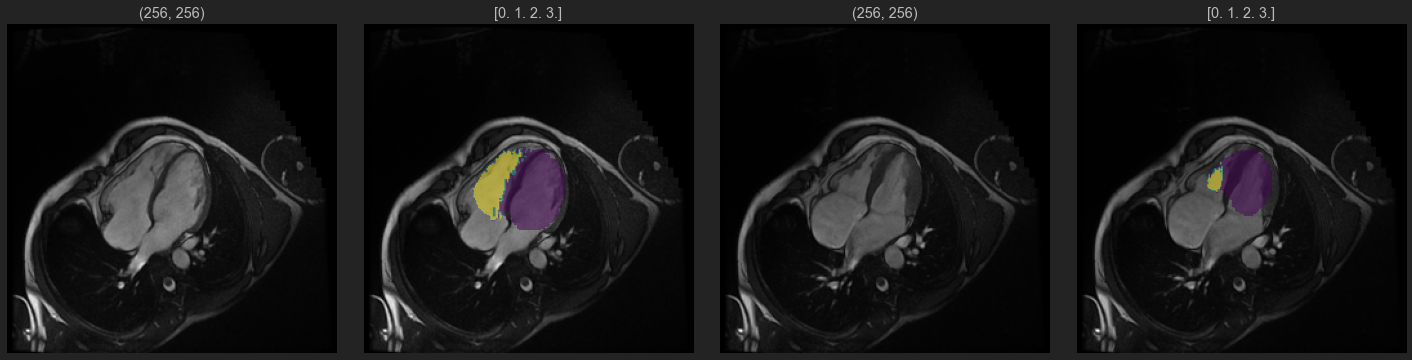

In [48]:
import matplotlib.pyplot as plt
import random

ix = random.randint(0, len(patients))
sample = patients[ix]
fig = plt.figure(figsize=(20,5))
ax = plt.subplot(1, 4, 1)
image_path = f'{path}/{sample}/{sample}_LA_ED.nii.gz'
img = nib.load(image_path).get_fdata()[...,0]
ax.imshow(img,cmap='gray')
ax.axis('off')
ax.set_title(img.shape)
ax = plt.subplot(1, 4, 2)
image_path = f'{dest}/{sample}/{sample}_LA_ED_pred.nii.gz'
mask = nib.load(image_path).get_fdata()[...,0]
ax.imshow(img, cmap='gray')
ax.set_title(np.unique(mask))
mask[mask == 0] = np.nan
ax.imshow(mask, alpha=0.5)
ax.axis('off')
ax = plt.subplot(1, 4, 3)
image_path = f'{path}/{sample}/{sample}_LA_ES.nii.gz'
img = nib.load(image_path).get_fdata()[...,0]
ax.imshow(img,cmap='gray')
ax.axis('off')
ax.set_title(img.shape)
ax = plt.subplot(1, 4, 4)
image_path = f'{dest}/{sample}/{sample}_LA_ES_pred.nii.gz'
mask = nib.load(image_path).get_fdata()[...,0]
ax.imshow(img, cmap='gray')
ax.set_title(np.unique(mask))
mask[mask == 0] = np.nan
ax.imshow(mask, alpha=0.5)
ax.axis('off')
plt.tight_layout()
plt.show()

C:\Users\sensio\miniconda3\lib\site-packages\matplotlib\image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
C:\Users\sensio\miniconda3\lib\site-packages\matplotlib\image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\Users\sensio\miniconda3\lib\site-packages\matplotlib\image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
C:\Users\sensio\miniconda3\lib\site-packages\numpy\core\_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


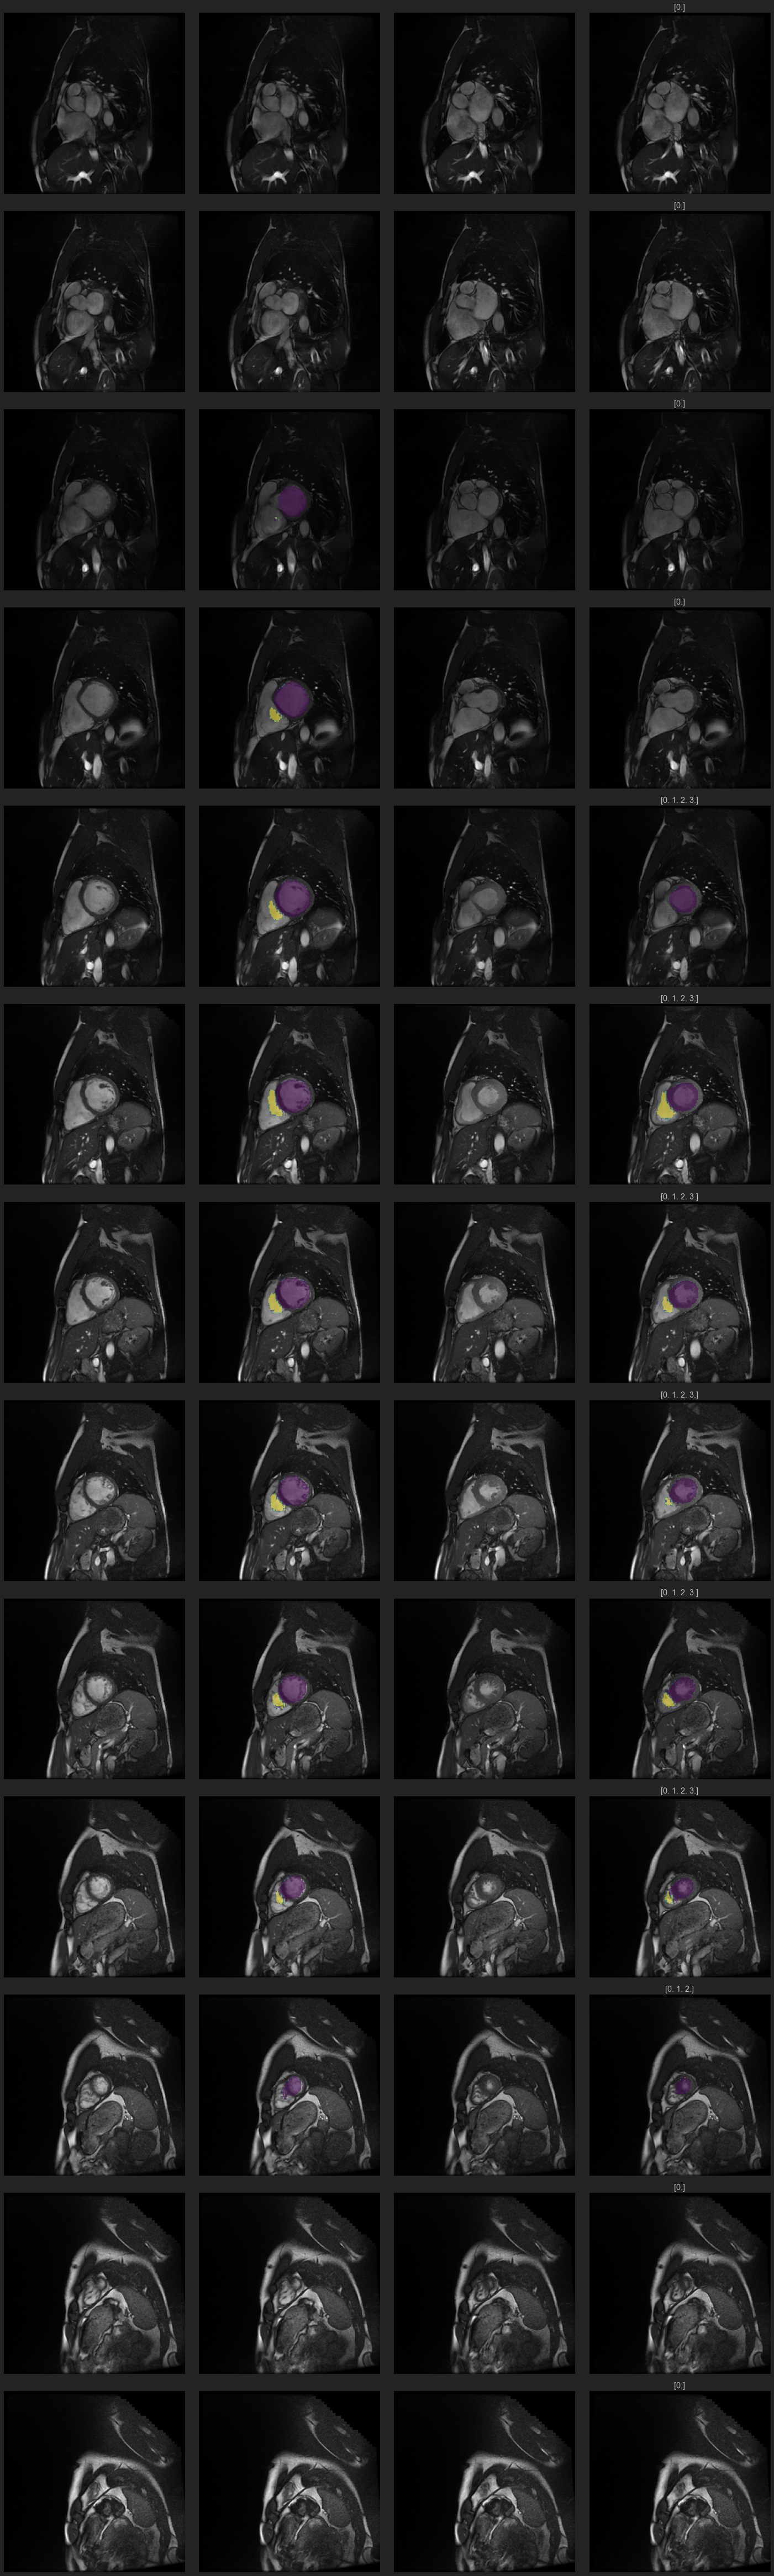

In [49]:
ed_img = nib.load(f'{path}/{sample}/{sample}_SA_ED.nii.gz').get_fdata()
channels = ed_img.shape[-1]

ed_pred = nib.load(f'{dest}/{sample}/{sample}_SA_ED_pred.nii.gz').get_fdata()
es_img = nib.load(f'{path}/{sample}/{sample}_SA_ES.nii.gz').get_fdata()
es_pred = nib.load(f'{dest}/{sample}/{sample}_SA_ES_pred.nii.gz').get_fdata()

fig = plt.figure(figsize=(20, channels*5))
for c in range(channels):
    ax = plt.subplot(channels, 4, 4*c + 1)
    ax.imshow(ed_img[...,c],cmap='gray')
    ax.axis('off')
    ax = plt.subplot(channels, 4, 4*c + 2)
    ax.imshow(ed_img[...,c], cmap='gray')
    mask = ed_pred[...,c]
    mask[mask == 0] = np.nan
    ax.imshow(mask, alpha=0.5)
    ax.axis('off')
    ax = plt.subplot(channels, 4, 4*c + 3)
    ax.imshow(es_img[...,c],cmap='gray')
    ax.axis('off')
    ax = plt.subplot(channels, 4, 4*c + 4)
    ax.imshow(es_img[...,c],cmap='gray')
    mask = es_pred[...,c]
    ax.set_title(np.unique(mask))
    mask[mask == 0] = np.nan
    ax.imshow(mask, alpha=0.5)
    ax.axis('off')
plt.tight_layout()
plt.show()